In [1]:
import time
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision.transforms.functional as F

from dataset import load_filtered_train_test_split
from train import train
import seg_metrics.seg_metrics as sg

from models.UNet import UNet
from models.ViT import ViT
from models.ViT_UNet import ViT_UNet

In [2]:
train_dataset, test_dataset = load_filtered_train_test_split()
print(len(train_dataset), len(test_dataset))

unet = torch.load('models/gpu_UNet_28012025_1705')
vit = torch.load('models/gpu_ViT_28012025_1712')
vit_unet = torch.load('models/gpu_ViT_UNet_28012025_1716')
unetr = torch.load('models/gpu_UNETR_28012025_1835')

Loading filtered 2D segmentation dataset...
1098 275


In [23]:
def show_comparison(imgs, titles):
    width = len(imgs)
    plt.figure(figsize=(15, 10))

    for i in range(len(imgs)):
        plt.subplot(1, width, i+1)
        plt.imshow(F.to_pil_image(imgs[i]), cmap='gray')
        plt.title(titles[i])
        plt.axis('off')


35
6
11
20
49
88


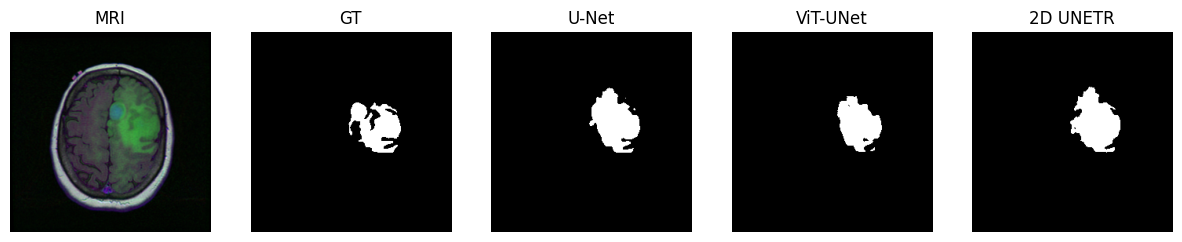

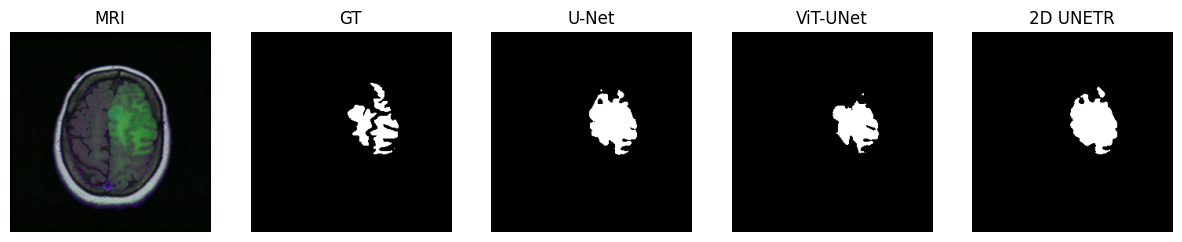

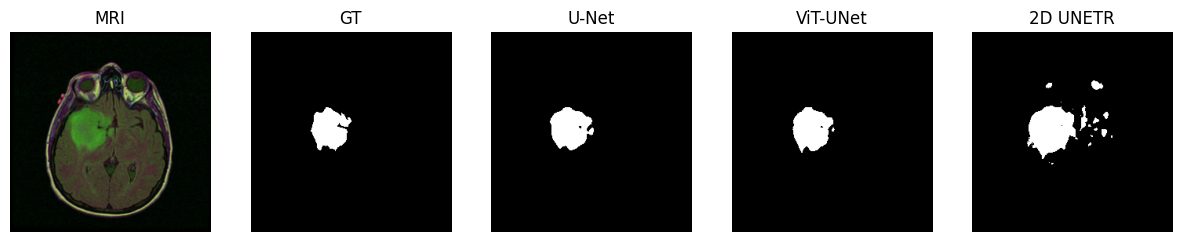

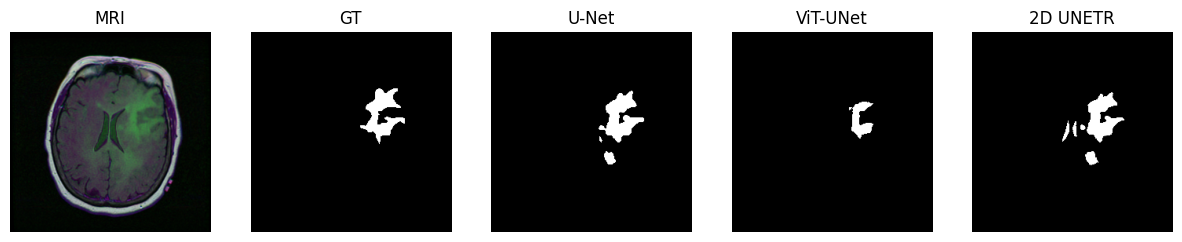

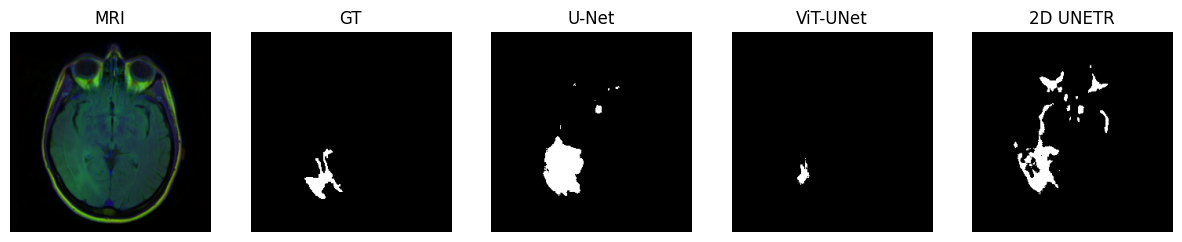

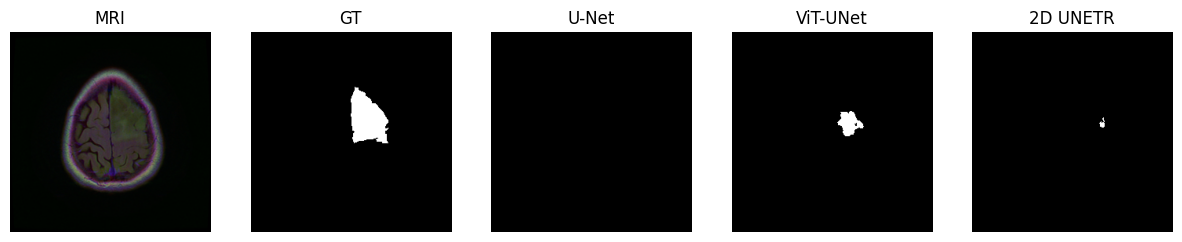

In [25]:
# indeces = [0, 3, 4, 8, 13, 14, 17, 18, 21, 26, 27, 28, 42, 45, 49, 51, 59, 61, 64, 69]
# indeces = [1, 3, 5, 6, 8, 11, 12, 13, 20, 28, 35, 40, 41, 49, 57, 69, 75, 88, 91, 95, 98]
# indeces = [5, 6, 11, 13, 20, 35, 49, 75, 88, 91]
indeces = [35, 6, 11, 20, 49, 88]

for i in indeces:
    X, Y = test_dataset[i]
    y_u = unet(X.unsqueeze(0)).squeeze()
    y_vu = vit_unet(X.unsqueeze(0)).squeeze()
    y_unetr = unetr(X.unsqueeze(0)).squeeze()

    y_u = torch.round(y_u)
    y_vu = torch.round(y_vu)
    y_unetr = torch.round(y_unetr)

    print(i)
    show_comparison([X, Y, y_u,y_vu, y_unetr], [f'MRI', 'GT', 'U-Net', 'ViT-UNet', '2D UNETR'])

In [7]:
# Dice scores and HD 95
# 20min

results_dice_u = []
results_dice_vu = []
results_dice_unetr = []

results_hd_u = []
results_hd_vu = []
results_hd_unetr = []

for i in range(len(test_dataset)):
    if (i+1) % 25 == 0:
        print(f'{i+1} / {len(test_dataset)}')

    X, Y = test_dataset[i]
    Y = Y.squeeze().detach().numpy()

    # Prediction probabilities
    y_u     = unet(X.unsqueeze(0)).squeeze()
    y_vu    = vit_unet(X.unsqueeze(0)).squeeze()
    y_unetr = unetr(X.unsqueeze(0)).squeeze()

    # Predicted output
    y_u     = torch.round(y_u).detach().numpy()
    y_vu    = torch.round(y_vu).detach().numpy()
    y_unetr = torch.round(y_unetr).detach().numpy()

    # If the predicted output contains a prediction, calculate metrics and store in lists
    if np.sum(y_u) > 0.:
        metrics_u   = sg.write_metrics(labels=[1.], gdth_img=Y, pred_img=y_u, metrics=['dice', 'hd95'])[0]
        dice_u      = metrics_u['dice'][0]
        hd95_u      = metrics_u['hd95'][0]
        results_dice_u.append(dice_u)
        results_hd_u.append(hd95_u)
    
    if np.sum(y_vu) > 0.:
        metrics_vu  = sg.write_metrics(labels=[1.], gdth_img=Y, pred_img=y_vu, metrics=['dice', 'hd95'])[0]
        dice_vu     = metrics_vu['dice'][0]
        hd95_vu     = metrics_vu['hd95'][0]
        results_dice_vu.append(dice_vu)
        results_hd_vu.append(hd95_vu)

    if np.sum(y_unetr) > 0.:
        metrics_unetr   = sg.write_metrics(labels=[1.], gdth_img=Y, pred_img=y_unetr, metrics=['dice', 'hd95'])[0]
        dice_unetr      = metrics_unetr['dice'][0]
        hd95_unetr      = metrics_unetr['hd95'][0]
        results_dice_unetr.append(dice_unetr)
        results_hd_unetr.append(hd95_unetr)


25 / 275
50 / 275
75 / 275
100 / 275
125 / 275
150 / 275
175 / 275
200 / 275
225 / 275
250 / 275
275 / 275


In [8]:
print('length results_dice_u:\t\t', len(results_dice_u))
print('length results_dice_vu:\t\t', len(results_dice_vu))
print('length results_dice_unetr:\t', len(results_dice_unetr))
print()

mean_dice_u = np.mean(results_dice_u)
mean_dice_vu = np.mean(results_dice_vu)
mean_dice_unetr = np.mean(results_dice_unetr)

print('Average Dice Scores:')
print(f'UNet:\t\t {mean_dice_u}')
print(f'ViT-UNet:\t {mean_dice_vu}')
print(f'UNETR:\t\t {mean_dice_unetr}')

length results_dice_u:		 219
length results_dice_vu:		 227
length results_dice_unetr:	 226

Average Dice Scores:
UNet:		 0.6863461075684595
ViT-UNet:	 0.6712939901357204
UNETR:		 0.6039595837741086


In [9]:
print('length results_hd_u:\t\t', len(results_hd_u))
print('length results_hd_vu:\t\t', len(results_hd_vu))
print('length results_hd_unetr:\t', len(results_hd_unetr))
print()

mean_hd_u = np.mean(results_hd_u)
mean_hd_vu = np.mean(results_hd_vu)
mean_hd_unetr = np.mean(results_hd_unetr)

print('Average HD95 Scores:')
print(f'UNet:\t\t {mean_hd_u}')
print(f'ViT-UNet:\t {mean_hd_vu}')
print(f'UNETR:\t\t {mean_hd_unetr}')

length results_hd_u:		 219
length results_hd_vu:		 227
length results_hd_unetr:	 226

Average HD95 Scores:
UNet:		 15.981560075881815
ViT-UNet:	 17.692246998721807
UNETR:		 28.662912457390153
